In [1]:
%load_ext autoreload
%autoreload 2

# 1. Synthetic to real domain gap
Take some real image crops from  Sam， with less occlusions，as the templates. And mach them with the raw crops from Sam. You can maybe apply a threshold for the Bounding box size to filter the valid template. See if you can get some reasonable results

## 1.1 Take and save some real image crops from SAM
Take input image then put via sam then choose some of the crops- save in the cnos analysis folder

In [2]:
# load sam
from src.model.sam import CustomSamAutomaticMaskGenerator, load_sam
from segment_anything.modeling.sam import Sam
model_type = "vit_h"
checkpoint_dir =  "datasets/bop23_challenge/pretrained/segment-anything"
sam_model = load_sam(model_type, checkpoint_dir)
custom_sam_model = CustomSamAutomaticMaskGenerator(sam=sam_model)

In [3]:
def move_to_device(segmentor_model, device="cuda:0"):
    # if there is predictor in the model, move it to device
    if hasattr(segmentor_model, "predictor"):
        segmentor_model.predictor.model = (
            segmentor_model.predictor.model.to(device)
        )
    else:
        segmentor_model.model.setup_model(device=device, verbose=True)
move_to_device(custom_sam_model)

In [4]:
from PIL import Image
import torch
import numpy as np
from src.model.utils import Detections
rgb_path = "cnos_analysis/crop_proposals/000001.png"
rgb = Image.open(rgb_path).convert("RGB")
detections = custom_sam_model.generate_masks(np.array(rgb))

In [5]:
def extract_object_by_mask(image, mask, width: int = 512):
    mask = Image.fromarray(mask)
    masked_image = Image.composite(
        image, Image.new("RGB", image.size, (0, 0, 0)), mask)
    cropped_image = masked_image.crop(masked_image.getbbox())
    # new_height = width * cropped_image.height // cropped_image.width
    return cropped_image

masked_images = []
for mask in detections["masks"].cpu():
    binary_mask = np.array(mask) * 255
    binary_mask = binary_mask.astype(np.uint8)
    masked_image = extract_object_by_mask(rgb, binary_mask)
    masked_images.append(masked_image)

In [6]:
# Visualize proposals
import matplotlib.pyplot as plt
from math import ceil
def plot_images(images, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 30))
    for i, ax in enumerate(axes.flat):
        if i >= len(images):
            break
        ax.imshow(images[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Define the number of rows and columns in the grid
rows = ceil(len(masked_images) / 6)
cols = 6
# Plot the masked_images array in a grid
# plot_images(masked_images, rows, cols) 

In [7]:
# We are choosing proposals 2 and 8
crop1 = {
    "crop" : masked_images[1], # it is saved as Image so crop1["crop"] to visualize it
    "masks" : detections["masks"][1],
    "boxes" : detections["boxes"][1]
}
crop2 = {
    "crop" : masked_images[2],
    "masks" : detections["masks"][2],
    "boxes" : detections["boxes"][2]
}

# save image
crop1["crop"].save("cnos_analysis/crop_proposals/crop1.png")
crop2["crop"].save("cnos_analysis/crop_proposals/crop2.png")

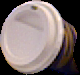

In [8]:
crop2["crop"]

## 1.2 a. Create and save 42 templates from the test folder using BlenderProc.

In [9]:
# load config file
import hydra
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose

# Initialize Hydra and compose the configuration
initialize(config_path="configs")
cfg = compose(config_name="run_inference")

/tmp/ipykernel_2488044/1465400466.py:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="configs")


In [10]:
# 10* set_struct to so that we can add key-value to the file - see lb we add new key-value root_dir to ref_dataloader_config
OmegaConf.set_struct(cfg, False)

In [11]:
default_ref_dataloader_config = cfg.data.reference_dataloader
ref_dataloader_config = default_ref_dataloader_config.copy()
ref_dataloader_config._target_ = "src.dataloader.bop_pbr.BOPTemplatePBR"
ref_dataloader_config.root_dir = "datasets/bop23_challenge/datasets/icbin"
ref_dataloader_config.template_dir += "templates_pyrender/icbin" # we r working on icbin dataset
ref_dataloader_config.templates_output_folder = "cnos_analysis/real_images_templates"


In [12]:
from hydra.utils import instantiate
ref_dataset = instantiate(ref_dataloader_config) # src.dataloader.bop.BOPTemplatePBR
ref_dataset.load_processed_metaData(reset_metaData=True)

INFO:lightning_lite.utilities.seed:Global seed set to 2023
INFO:lightning_lite.utilities.seed:Global seed set to 2023


InstantiationException: Error in call to target 'src.dataloader.bop_pbr.BOPTemplatePBR':
FileNotFoundError(2, 'No such file or directory')
full_key: data.reference_dataloader

In [ ]:
import pandas as pd
# cnos_analysis/test_processed_metaData.csv has size of 84 templates for 2 models# cnos_analysis/test_metaData.csv is has size of 2250 tempaltes - it is before we choose 42 templates for each
templates = pd.read_csv("cnos_analysis/test_processed_metaData.csv")

In [ ]:
# Save templates as images
from torchvision.utils import save_image
import os
for ob_id in range(1,len(templates)//42+1):
    obj_id_path = os.path.join("cnos_analysis/real_images_templates/icbin", f'obj_{(ob_id):06d}') ## achtung 06d not just 6d
    original_obj_id_path = os.path.join("cnos_analysis/real_images_templates/icbin", f'obj_{(ob_id):06d}_original')
    
    if not os.path.exists(obj_id_path):
        os.makedirs(obj_id_path)
    if not os.path.exists(original_obj_id_path):
        os.makedirs(original_obj_id_path)

    for i, img in enumerate(ref_dataset[ob_id-1]["templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
        save_image(img, os.path.join(obj_id_path, f'{i:06d}.png'))
    for i, img in enumerate(ref_dataset[ob_id-1]["original_templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
        save_image(img, os.path.join(original_obj_id_path, f'{i:06d}.png'))


## 1.2 b. Create and save 42 templates from the train_pbr folder using BlenderProc.

In [ ]:
default_ref_dataloader_config = cfg.data.reference_dataloader
ref_dataloader_config = default_ref_dataloader_config.copy()
ref_dataloader_config._target_ = "src.dataloader.bop_pbr.BOPTemplatePBR"
ref_dataloader_config.root_dir = "datasets/bop23_challenge/datasets/icbin"
ref_dataloader_config.template_dir += "templates_pyrender/icbin" # we r working on icbin dataset
ref_dataloader_config.templates_output_folder = "cnos_analysis/synthetic_images_templates"
ref_dataloader_config.split = "train_pbr"

In [ ]:
from hydra.utils import instantiate
ref_dataset = instantiate(ref_dataloader_config) # src.dataloader.bop.BOPTemplatePBR
ref_dataset.load_processed_metaData(reset_metaData=True)

Loading metaData: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]
Finding nearest rendering close to template poses: 100%|██████████| 2/2 [00:00<00:00, 129.71it/s]


In [ ]:
import pandas as pd
# cnos_analysis/test_processed_metaData.csv has size of 84 templates for 2 models# cnos_analysis/test_metaData.csv is has size of 2250 tempaltes - it is before we choose 42 templates for each
templates = pd.read_csv("cnos_analysis/train_pbr_processed_metaData.csv")

In [ ]:
# Save templates as images
from torchvision.utils import save_image
import os
for ob_id in range(1,len(templates)//42+1):
    obj_id_path = os.path.join("cnos_analysis/real_images_templates/icbin/train_pbr", f'obj_{(ob_id):06d}') ## achtung 06d not just 6d
    original_obj_id_path = os.path.join("cnos_analysis/real_images_templates/icbin/train_pbr", f'obj_{(ob_id):06d}_original')
    
    if not os.path.exists(obj_id_path):
        os.makedirs(obj_id_path)
    if not os.path.exists(original_obj_id_path):
        os.makedirs(original_obj_id_path)

    for i, img in enumerate(ref_dataset[ob_id-1]["templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
        save_image(img, os.path.join(obj_id_path, f'{i:06d}.png'))
    for i, img in enumerate(ref_dataset[ob_id-1]["original_templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
        save_image(img, os.path.join(original_obj_id_path, f'{i:06d}.png'))


## 1.3 Extract feature descriptors for the 42 templates


### For real template images

In [ ]:
# define the cnos model
cfg_segmentor = cfg.model.segmentor_model
if "fast_sam" in cfg_segmentor._target_:
    logging.info("Using FastSAM, ignore stability_score_thresh!")
else:
    cfg.model.segmentor_model.stability_score_thresh = 0.97 # for sam

model = instantiate(cfg.model).to("cuda")

Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main
/home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [ ]:
import glob
import logging
from src.utils.bbox_utils import CropResizePad
# can also put the tranform for the image before going via Dino - but actually I tested that and it is actually the same

template_dir = "cnos_analysis/real_images_templates/icbin/obj_000001"
template_paths = glob.glob(f"{template_dir}/*.png")
boxes, templates = [], []
for path in template_paths:
    image = Image.open(path)
    boxes.append(image.getbbox())
    image = torch.from_numpy(np.array(image.convert("RGB")) / 255).float() # convert templates in format of Image to np then devide them by 255
    templates.append(image)
    
templates = torch.stack(templates).permute(0, 3, 1, 2) # now qw have a stack of 42,3,480*640
boxes = torch.tensor(np.array(boxes))

processing_config = OmegaConf.create(
    {
        "image_size": 224,
    }
)
proposal_processor = CropResizePad(processing_config.image_size)
templates = proposal_processor(images=templates, boxes=boxes).cuda() # here resize the templates to size of 42,3,224,224 I assume
save_image(templates, f"{template_dir}/cnos_results/templates.png", nrow=7) # here just put all templates in 1 image and save it
ref_features = model.descriptor_model.compute_features(
                templates, token_name="x_norm_clstoken"
            ) # extract features for the 42 templates - obtain shape as 42,1024
logging.info(f"Ref feats: {ref_features.shape}")

In [ ]:
ref_features.shape

torch.Size([42, 1024])

### For synthetic template images

In [ ]:
import glob
import logging
from src.utils.bbox_utils import CropResizePad
# can also put the tranform for the image before going via Dino - but actually I tested that and it is actually the same

synthetic_template_dir = "cnos_analysis/real_images_templates/icbin/train_pbr_templates/obj_000001"
synthetic_template_paths = glob.glob(f"{synthetic_template_dir}/*.png")
synthetic_boxes, synthetic_templates = [], []
for path in synthetic_template_paths:
    image = Image.open(path)
    synthetic_boxes.append(image.getbbox())
    image = torch.from_numpy(np.array(image.convert("RGB")) / 255).float() # convert templates in format of Image to np then devide them by 255
    synthetic_templates.append(image)
    
synthetic_templates = torch.stack(synthetic_templates).permute(0, 3, 1, 2) # now qw have a stack of 42,3,480*640
synthetic_boxes = torch.tensor(np.array(synthetic_boxes))

processing_config = OmegaConf.create(
    {
        "image_size": 224,
    }
)
synthetic_proposal_processor = CropResizePad(processing_config.image_size)
synthetic_templates = synthetic_proposal_processor(images=synthetic_templates, boxes=synthetic_boxes).cuda() # here resize the templates to size of 42,3,224,224 I assume
save_image(synthetic_templates, "cnos_analysis/real_images_templates/icbin/train_pbr_templates/normalized_synthetic_templates.png", nrow=7) # here just put all templates in 1 image and save it
synthetic_ref_features = model.descriptor_model.compute_features(
                synthetic_templates, token_name="x_norm_clstoken"
            ) # extract features for the 42 templates - obtain shape as 42,1024

In [ ]:
synthetic_ref_features.shape

torch.Size([42, 1024])

## 1.5 Extract features from the crop
Scale and pad the crops to size of (224,224) before going through Dinov2

In [ ]:
import torchvision.transforms as T
import torch.nn.functional as F

def crop_feature_extraction(crop_rgb, cnos_model):
    # crop_rgb: numpy array
    rgb_normalize = T.Compose(
        [
            T.ToTensor(),
            T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ]
    )
    normalized_crop_rgb = rgb_normalize(crop_rgb).float()

    # Scale image to 224
    target_max = 224
    scale_factor = target_max / torch.max(torch.tensor(normalized_crop_rgb.shape)) # 224/max of x1,y1,x2,y2
    scaled_crop_rgb = F.interpolate(normalized_crop_rgb.unsqueeze(0), scale_factor=scale_factor.item())[0] # Shape [3, 176, 224])
    
    # Padding 0 to 3,224,224
    original_h, original_w = scaled_crop_rgb.shape[1:]
    original_ratio = original_w / original_h
    target_h, target_w = 224, 224
    target_ratio  = target_w/target_h 
    if  target_ratio != original_ratio: 
        padding_top = max((target_h - original_h) // 2, 0)
        padding_bottom = target_h - original_h - padding_top
        padding_left = max((target_w - original_w) // 2, 0)
        padding_right = target_w - original_w - padding_left
        scaled_padded_crop_rgb = F.pad(
        scaled_crop_rgb, (padding_left, padding_right, padding_top, padding_bottom)
        )
    scaled_padded_crop_rgb = scaled_padded_crop_rgb.unsqueeze(0) # unsqueeze to make it as a stack of proposals - here we use only 1 proposals
    print("scaled_padded_crop_rgb.shape", scaled_padded_crop_rgb.shape) # Should be 1,3,224,224 - if not then do line 122 in src/utils/bbox_utils.py
    
    feature_decriptors = cnos_model.descriptor_model.forward_by_chunk(scaled_padded_crop_rgb.to("cuda"))
    # Forward_by_chunk cos we already process all the prosals that we get the processed_rgbs = scaled_padded_crop_rgb from previous steps already
    print("feature_decriptors.shape", feature_decriptors.shape)

    # Display the image - 10* see lb the crop is normalized same way as the templates- ready to compare the similarity now
    plt.imshow(scaled_padded_crop_rgb[0].permute(1,2,0))
    plt.axis('off')  # Optional: Turn off the axis
    plt.show()
    return feature_decriptors

### For normal crop

In [ ]:
crop_rgb = np.array(Image.open("cnos_analysis/crop_proposals/crop1.png").convert("RGB")) # (124, 157, 3)

scaled_padded_crop_rgb.shape torch.Size([1, 3, 224, 224])


feature_decriptors.shape torch.Size([1, 1024])


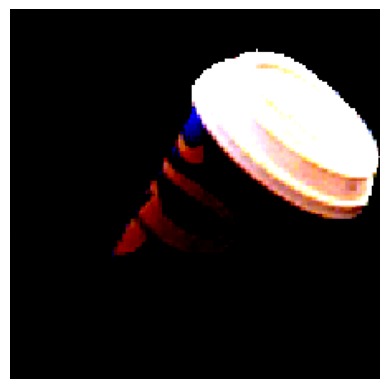

In [ ]:
feature_decriptors  = crop_feature_extraction(crop_rgb, model)

### For occluded crop

In [ ]:
import copy
crop_rgb = np.array(Image.open("cnos_analysis/crop_proposals/crop1.png").convert("RGB")) # (124, 157, 3)
occluded_crop_rgb = copy.deepcopy(crop_rgb)

In [ ]:
h, w,_ = occluded_crop_rgb.shape
occluded_crop_rgb[h//2:,w//3:,:] = 0

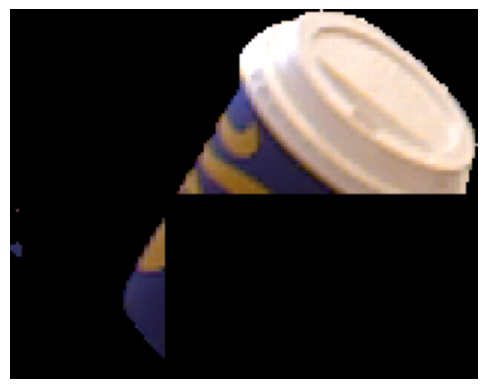

In [ ]:
# Display the image - 10* see lb the crop is normalized same way as the templates- ready to compare the similarity now
plt.imshow(occluded_crop_rgb)
plt.axis('off')  # Optional: Turn off the axis
plt.show()

scaled_padded_crop_rgb.shape torch.Size([1, 3, 224, 224])


feature_decriptors.shape torch.Size([1, 1024])


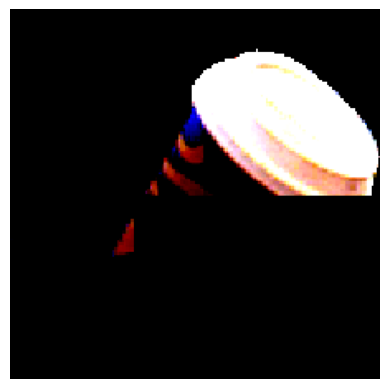

In [ ]:
# Extract feature
occluded_feature_decriptors = crop_feature_extraction(occluded_crop_rgb, model)

### For small crop

In [ ]:
small_crop_rgb = np.array(Image.open("cnos_analysis/crop_proposals/crop2.png").convert("RGB")) # (124, 157, 3)


scaled_padded_crop_rgb.shape torch.Size([1, 3, 224, 224])
feature_decriptors.shape torch.Size([1, 1024])


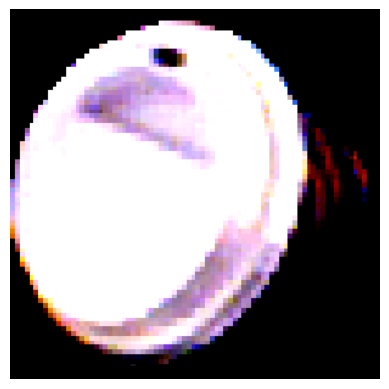

In [ ]:
# Extract feature
small_feature_decriptors = crop_feature_extraction(small_crop_rgb, model)

#### For zoom_in and zoom_out crop
10* 
Zoom In (Upscaling): Increase the size of the image.
Zoom Out (Downscaling): Decrease the size of the image.

In [ ]:
from scipy.ndimage import zoom
def zoom_in(image, scale):
    return zoom(image, (scale, scale, 1))

def zoom_out(image, scale):
    return zoom(image, (1/scale, 1/scale, 1))

crop_rgb = np.array(Image.open("cnos_analysis/crop_proposals/crop1.png").convert("RGB")) # (124, 157, 3)
zoom_scale = 3  # Zoom in by a factor of 2
crop_rgb_zoomed_in = zoom_in(crop_rgb, zoom_scale)
crop_rgb_zoomed_out = zoom_out(crop_rgb, zoom_scale)

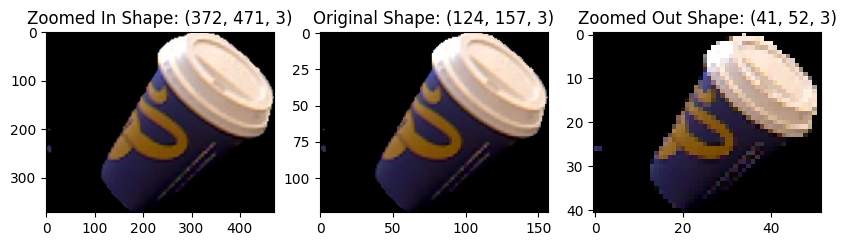

In [ ]:
# Display the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title(f"Zoomed In Shape: {crop_rgb_zoomed_in.shape}")
plt.imshow(crop_rgb_zoomed_in)

plt.subplot(1, 3, 2)
plt.title(f"Original Shape: {crop_rgb.shape}")
plt.imshow(crop_rgb)

plt.subplot(1, 3, 3)
plt.title(f"Zoomed Out Shape: {crop_rgb_zoomed_out.shape}")
plt.imshow(crop_rgb_zoomed_out)

scaled_padded_crop_rgb.shape torch.Size([1, 3, 224, 224])
feature_decriptors.shape torch.Size([1, 1024])


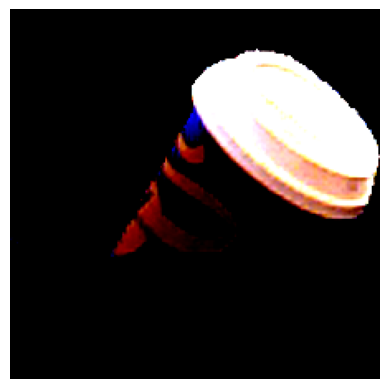

In [ ]:
feature_decriptors_zoomed_in = crop_feature_extraction(crop_rgb_zoomed_in, model)

scaled_padded_crop_rgb.shape torch.Size([1, 3, 224, 224])
feature_decriptors.shape torch.Size([1, 1024])


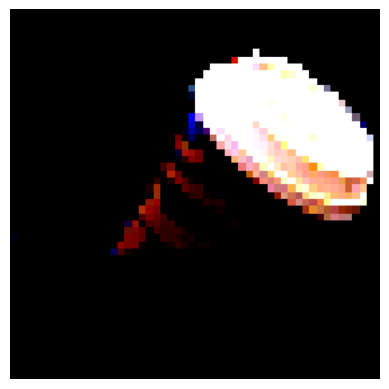

In [ ]:
feature_decriptors_zoomed_out = crop_feature_extraction(crop_rgb_zoomed_out, model)

## 1.4 Calculate the similarity 
Now we have feature_descriptors and reference_descriptors, we can compute simlarity between reference discriptors(from templates) and features descriptors(from input image) and get the top 5 most similar templates to the crop



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from src.model.loss import PairwiseSimilarity, Similarity
from torchvision.io import read_image
metric = Similarity() # cnos  uses PairwiseSimilariy - what is the difference between Similarity and Pairwise Similarity ?

def calculate_similarity(crop_rgb, feature_decriptors, ref_features, metric, synthetic=False):
    # get scores per proposal
    scores = metric(feature_decriptors[:, None, :], ref_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_prosals*num_templates instead
    score_per_detection, similar_template_indices = torch.topk(scores, k=5, dim=-1) # get top 5 most similar templates
    # get the final confidence score
    score_per_detection = torch.mean(
        score_per_detection, dim=-1
    ) 
    # Check the confidence scores for the similar templates
    similar_scores = scores[:, similar_template_indices[0].to("cpu")]

    similar_templates = []
    for i in range(len(similar_template_indices[0])):
        if synthetic:
            img = read_image(f"cnos_analysis/real_images_templates/icbin/train_pbr_templates/obj_000001_original/{(similar_template_indices[0][i]):06d}.png")            
        else:
            img = read_image(f"cnos_analysis/real_images_templates/icbin/obj_000001_original/{(similar_template_indices[0][i]):06d}.png")        
        similar_templates.append(img)
    tempplate_images = torch.stack(similar_templates)

    # Display the crop
    plt.imshow(crop_rgb)
    plt.axis('off')  # Optional: Turn off the axis
    plt.show()

    print("top 5 confidence scores", similar_scores)
    print("final average confidence score", score_per_detection)

    w = 10
    h = 10
    fig = plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    for i in range(1, len(tempplate_images)+1):
        img = np.random.randint(10, size=(h,w))
        fig.add_subplot(rows, columns, i)
        plt.imshow(tempplate_images[i-1].permute(1,2,0))
    plt.show()
    return

### For real template images

#### For normal crop

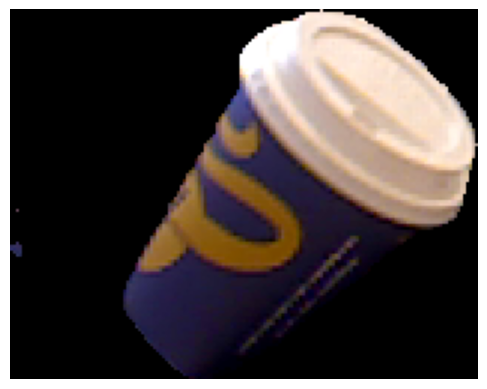

top 5 confidence scores tensor([[0.7206, 0.6810, 0.6584, 0.6573, 0.6523]], device='cuda:0')
final average confidence score tensor([0.6739], device='cuda:0')


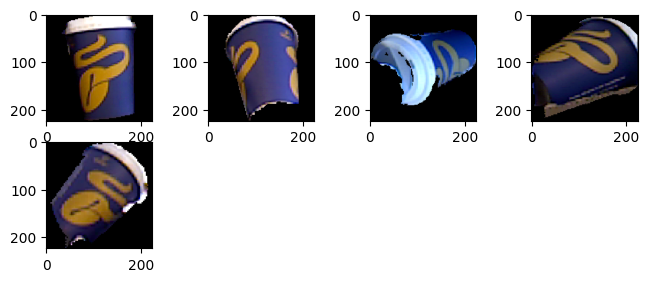

In [ ]:
calculate_similarity(crop_rgb, feature_decriptors, ref_features, metric, synthetic=False)

#### For occluded crop

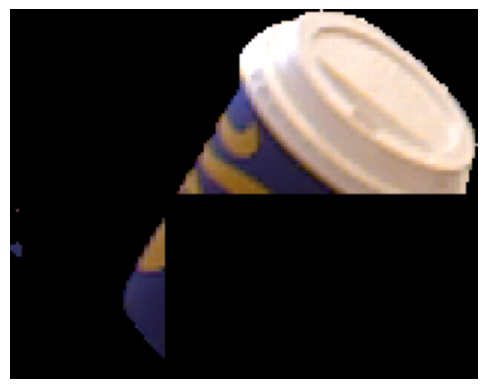

top 5 confidence scores tensor([[0.7466, 0.7339, 0.7024, 0.6662, 0.6574]], device='cuda:0')
final average confidence score tensor([0.7013], device='cuda:0')


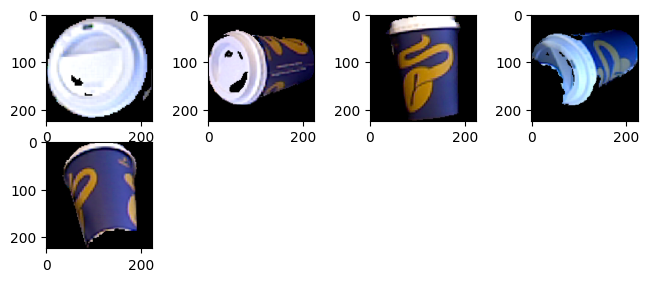

In [ ]:
calculate_similarity(occluded_crop_rgb, occluded_feature_decriptors, ref_features, metric, synthetic=False)

#### For small crop

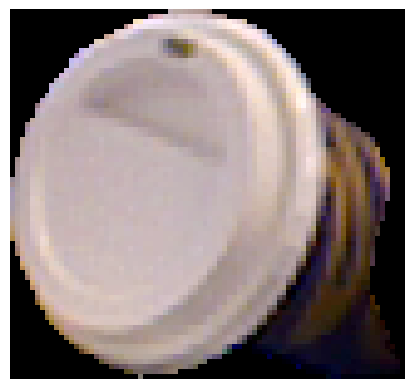

top 5 confidence scores tensor([[0.6129, 0.5959, 0.5032, 0.4682, 0.4581]], device='cuda:0')
final average confidence score tensor([0.5276], device='cuda:0')


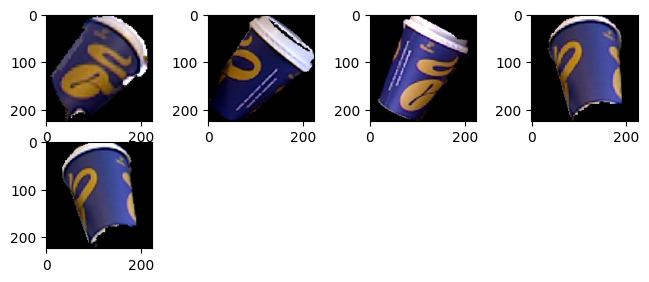

In [ ]:
calculate_similarity(small_crop_rgb, small_feature_decriptors, ref_features, metric, synthetic=False) 

#### For zoomed in crop

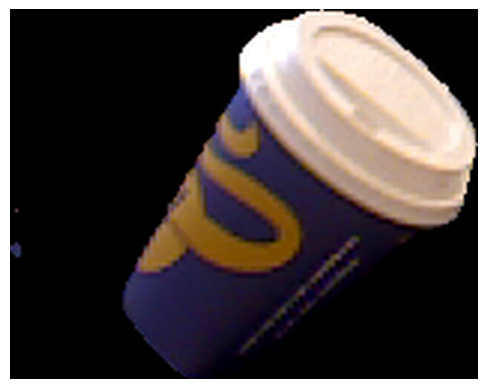

top 5 confidence scores tensor([[0.6923, 0.6730, 0.6368, 0.6338, 0.6291]], device='cuda:0')
final average confidence score tensor([0.6530], device='cuda:0')


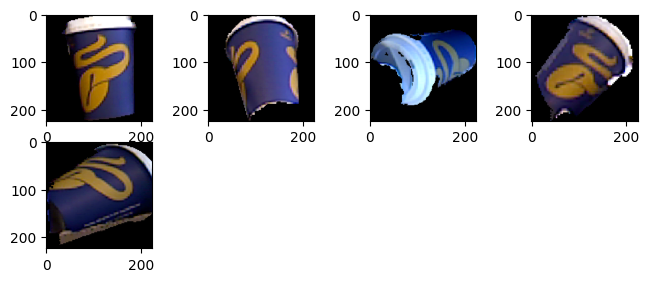

In [ ]:
calculate_similarity(crop_rgb_zoomed_in, feature_decriptors_zoomed_in, ref_features, metric, synthetic=False) 

#### For zoomed out crop

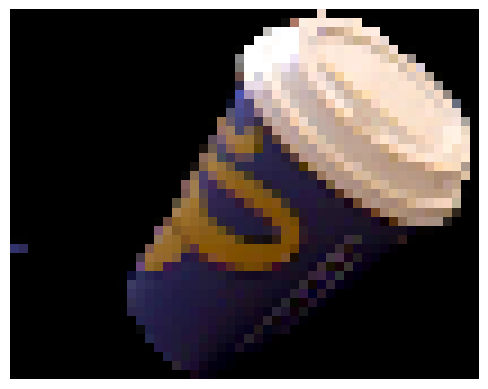

top 5 confidence scores tensor([[0.7515, 0.7400, 0.7247, 0.7010, 0.7002]], device='cuda:0')
final average confidence score tensor([0.7235], device='cuda:0')


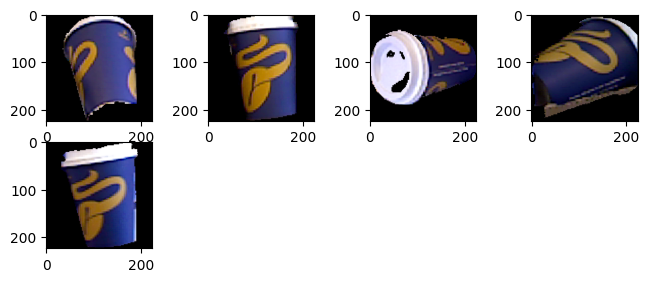

In [ ]:
calculate_similarity(crop_rgb_zoomed_out, feature_decriptors_zoomed_out, ref_features, metric, synthetic=False) 

### For synthetic template images

#### For normal crop

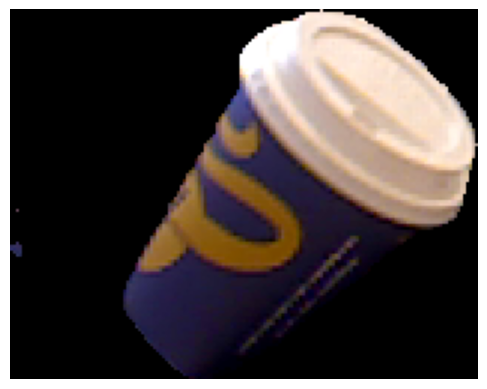

top 5 confidence scores tensor([[0.7408, 0.7160, 0.6936, 0.6904, 0.6670]], device='cuda:0')
final average confidence score tensor([0.7015], device='cuda:0')


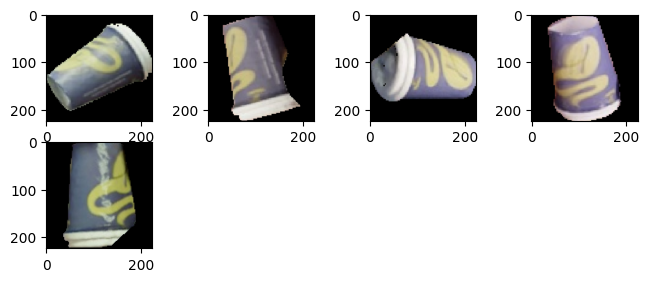

In [ ]:
calculate_similarity(crop_rgb, feature_decriptors, synthetic_ref_features, metric, synthetic=True) 

#### For occluded crop

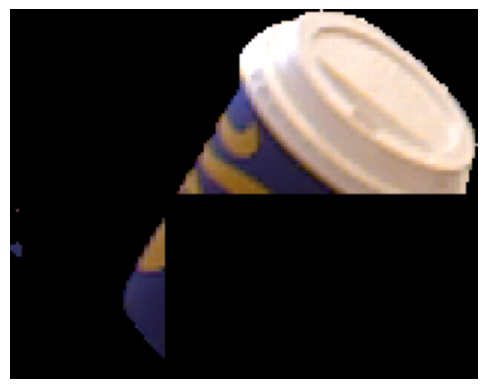

top 5 confidence scores tensor([[0.7266, 0.6984, 0.5978, 0.5966, 0.5675]], device='cuda:0')
final average confidence score tensor([0.6374], device='cuda:0')


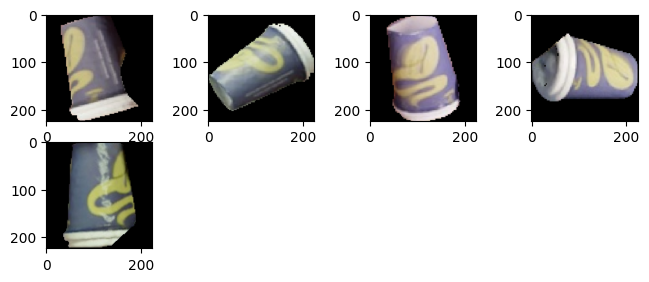

In [ ]:
calculate_similarity(occluded_crop_rgb, occluded_feature_decriptors, synthetic_ref_features, metric, synthetic=True) 

#### For small crop

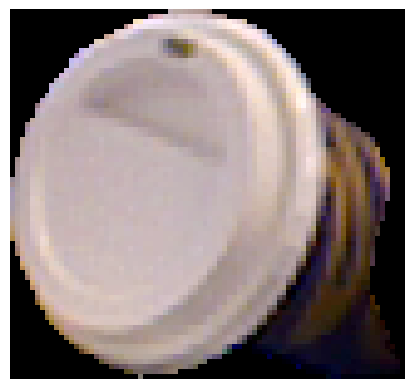

top 5 confidence scores tensor([[0.4283, 0.4165, 0.3764, 0.3657, 0.3421]], device='cuda:0')
final average confidence score tensor([0.3858], device='cuda:0')


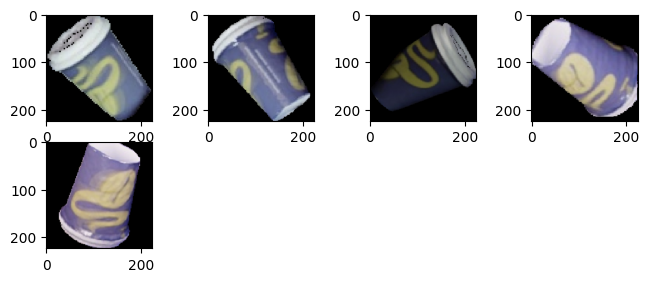

In [ ]:
calculate_similarity(small_crop_rgb, small_feature_decriptors, synthetic_ref_features, metric, synthetic=True) 

#### For zoomed in crop

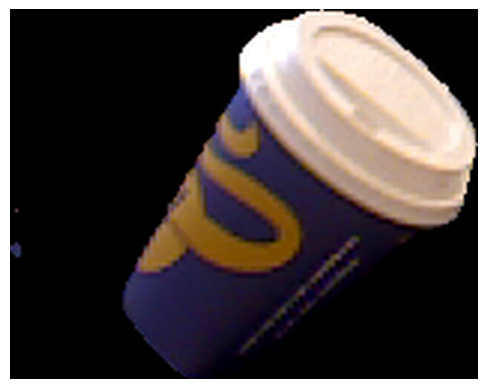

top 5 confidence scores tensor([[0.7289, 0.6935, 0.6723, 0.6592, 0.6489]], device='cuda:0')
final average confidence score tensor([0.6806], device='cuda:0')


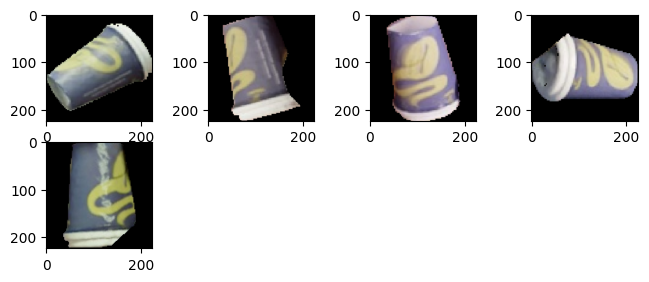

In [ ]:
calculate_similarity(crop_rgb_zoomed_in, feature_decriptors_zoomed_in, synthetic_ref_features, metric, synthetic=True) 

#### For zoom out crop

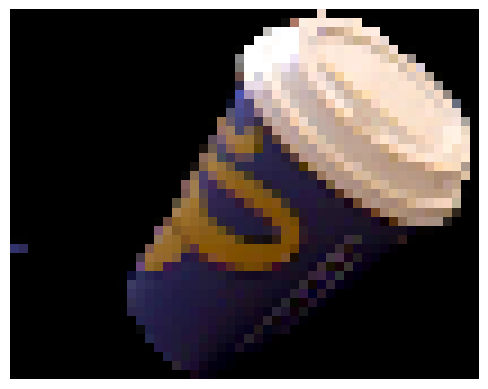

top 5 confidence scores tensor([[0.7970, 0.7507, 0.7164, 0.7126, 0.6853]], device='cuda:0')
final average confidence score tensor([0.7324], device='cuda:0')


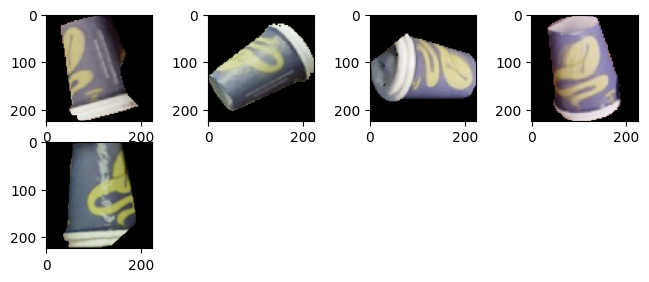

In [ ]:
calculate_similarity(crop_rgb_zoomed_out, feature_decriptors_zoomed_out, synthetic_ref_features, metric, synthetic=True) 

# 2. Test on image with realistic templates
Use templates from the test folder

### Initiate cnos model

In [ ]:
model = instantiate(cfg.model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.descriptor_model.model = model.descriptor_model.model.to(device)
model.descriptor_model.model.device = device
# if there is predictor in the model, move it to device
if hasattr(model.segmentor_model, "predictor"):
    model.segmentor_model.predictor.model = (
        model.segmentor_model.predictor.model.to(device)
    )
else:
    model.segmentor_model.model.setup_model(device=device, verbose=True)
logging.info(f"Moving models to {device} done!")

Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main


In [ ]:
from PIL import Image
import torch
import numpy as np
from src.model.utils import Detections
rgb_path = "cnos_analysis/crop_proposals/000001.png"
rgb = Image.open(rgb_path).convert("RGB")
detections = model.segmentor_model.generate_masks(np.array(rgb))
detections = Detections(detections)
decriptors = model.descriptor_model.forward(np.array(rgb), detections)
    

In [ ]:
# get scores per proposal
scores = metric(decriptors[:, None, :], ref_features[None, :, :])
score_per_detection = torch.topk(scores, k=5, dim=-1)[0]
score_per_detection = torch.mean(
    score_per_detection, dim=-1
)

In [ ]:
scores.to("cpu")

tensor([[0.1490, 0.1546, 0.2093,  ..., 0.1343, 0.1842, 0.1608],
        [0.2233, 0.6591, 0.4656,  ..., 0.4145, 0.6328, 0.5235],
        [0.4512, 0.3228, 0.3162,  ..., 0.2361, 0.4490, 0.2142],
        ...,
        [0.2199, 0.1222, 0.1457,  ..., 0.1121, 0.1463, 0.1180],
        [0.3388, 0.1738, 0.2032,  ..., 0.1977, 0.2706, 0.1651],
        [0.2567, 0.1757, 0.2401,  ..., 0.2073, 0.1750, 0.1662]])

In [ ]:
# get top-k detections
num_max_dets = 10
scores, index = torch.topk(score_per_detection, k=num_max_dets, dim=-1)
detections.filter(index)

In [ ]:
# # keep only detections with score > conf_threshold
# conf_threshold = 0.5
# detections.filter(scores>conf_threshold)
# detections.add_attribute("scores", scores)
# detections.add_attribute("object_ids", torch.zeros_like(scores))
    
# detections.to_numpy()
# save_path = "cnos_analysis/test_on_image/"
# detections.save_to_file(0, 0, 0, save_path, "custom", return_results=False)
# detections = convert_npz_to_json(idx=0, list_npz_paths=[save_path+".npz"])
# save_json_bop23(save_path+".json", detections)
# vis_img = visualize(rgb, detections)
# vis_img.save("cnos_analysis/test_on_image/vis.png")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
poses = np.load("src/poses/predefined_poses/cam_poses_level0.npy")

In [ ]:
poses.shape

(42, 4, 4)

# 3. inplane rotation (check if the 2 features or image and rotatted image are much different- so compare 2 vectors (1,1024)), zoom in and zoom out (do it correctly now), occlusion (real occulsion, like zoom it in), check the other occluded crop

# 4. Read foundpose and see how they use Dinov2 to extract features- then apply it for cnos to see if we get bettter matches with similar pose- then check for full image to see if the results are improved

# 5. Render real templates from CAD models and check if the results are improved